# COGS 108 - Final Project 

# Overview

Parks are a great aspect of any city and provide numerous benefits to its citizens. However, there are often parks that are under-maintained and need improvement. In this study, I will attempt to find out what people in San Diego enjoy the most and least about the parks from Yelp reviews. Using this feedback, the San Diego Parks and Recreation department can see how the parks are enriching people's lives and how they can be improved.

# Name & GitHub ID

- Name: Claire Stone
- GitHub Username: c2stone

# Research Question

What do people in San Diego enjoy the most and the least about local parks?


## Background and Prior Work

Parks are a valuable part of cities. There are numerous benefits and things that people enjoy about them, but there are also aspects that can make a park not as enjoyable. There have been many studies related to the benefits of parks. These include providing a place for people to exercise, socialize with family and friends, and enjoy being outside in nature. There are also environmental and health benefits such as improving water and air quality, and community benefits such as crime reduction (1). Although all parks have the potential to provide all of these benefits, if they are not properly maintained there can be problems that are detrimental to people's enjoyment of them. Problems can include poor security, crowds, and litter.

References (include links):
- 1) "Importance of Parks and Recreation" - Eastern Kentucky University (https://recreation.eku.edu/importance-parks-and-recreation)

# Hypothesis


I predict that people will enjoy the aesthetics and socializing in the open space the most. I predict they will dislike litter in parks the least.

# Dataset(s)

- Dataset Name: San Diego Parks Yelp Reviews
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_reviews.csv
- Number of observations: 2333 total. Using 647 of these.

This dataset has Yelp reviews for the San Diego parks. It includes 3 random reviews from each park and the ratings given by each reviewer.

# Setup

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.probability import FreqDist
import string

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# Load Yelp data
data = pd.read_csv('yelp_SD_reviews.csv')
data.shape


(2333, 3)

In [3]:
# Only keep rows with 'Park' in the ID column - this will remove most of the other places such as restaurants
yelp_rev = data[data['id'].str.contains('Park')]

# Remove rows with ids with 'North Park' - there are some businesses such as the Observatory North Park
# which are not parks. The remaining rows should be mostly parks.
yelp_rev = yelp_rev[~yelp_rev['id'].str.contains('North Park')]

# Take the 4 and 5 star reviews for what people like.
yelp_rev_p = yelp_rev.loc[(yelp_rev['rating'] == 5) | (yelp_rev['rating']==4)]

# Take the 1 and 2 star reviews for what people don't like.
yelp_rev_n = yelp_rev.loc[(yelp_rev['rating'] == 2) | (yelp_rev['rating']==1)]

# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [4]:
# Tokenize reviews
yelp_rev_p['rev_token'] = yelp_rev_p['text'].apply(word_tokenize)
yelp_rev_n['rev_token'] = yelp_rev_n['text'].apply(word_tokenize)

# Remove stopwords
yelp_rev_p['rev_stop'] = yelp_rev_p['rev_token'].apply(lambda x: [item for item in x if item not in stop_words])
yelp_rev_n['rev_stop'] = yelp_rev_n['rev_token'].apply(lambda x: [item for item in x if item not in stop_words])

# Stemming
yelp_rev_p['rev_stem'] = yelp_rev_p['rev_stop'].apply(lambda x: [ps.stem(y) for y in x])
yelp_rev_n['rev_stem'] = yelp_rev_n['rev_stop'].apply(lambda x: [ps.stem(y) for y in x])

# Stack
rev_words_p = yelp_rev_p['rev_stem'].apply(pd.Series).stack()
rev_words_n = yelp_rev_n['rev_stem'].apply(pd.Series).stack()


In [5]:
# Calculate word frequency and remove punctuation
rev_fdist_p = FreqDist(rev_words_p)
rev_fdist_n = FreqDist(rev_words_n)

for punc in string.punctuation:
    del rev_fdist_p[punc]
    del rev_fdist_n[punc]

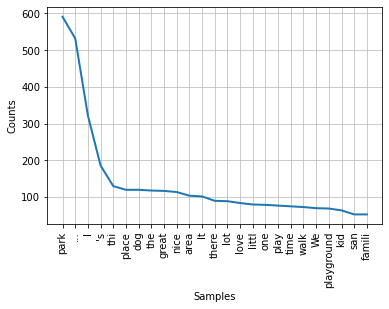

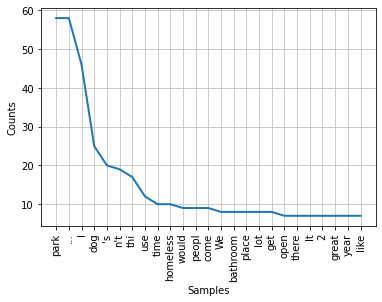

In [6]:
# Plot frequency distribution - top 25 words
rev_fdist_p.plot(25, cumulative = False)
rev_fdist_n.plot(25, cumulative = False)

# These plots show the most frequently used words for the positive and negative reviews.

In [7]:
## TF-IDF Analysis

import string 

# Change text to lowercase
p_list = list(yelp_rev_p['text'].values)
n_list = list(yelp_rev_n['text'].values)

rev_pl = list(map(str.lower, p_list))
rev_nl = list(map(str.lower, n_list))

# Remove punctuation
for i in string.punctuation:
    rev_pl = str(rev_pl).replace(i, "")
    rev_nl = str(rev_nl).replace(i, "")

# Create corpus
corpus = [str(rev_pl), str(rev_nl)]

# Create vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000, tokenizer=word_tokenize,
                        stop_words=stop_words)


In [8]:
# Calculate TF-IDF
yelp_tfidf = pd.DataFrame(tfidf.fit_transform(corpus).toarray())
yelp_tfidf.columns = tfidf.get_feature_names()
yelp_tfidf = yelp_tfidf.rename(index={0:'pos', 1:'neg'})


In [9]:
# TF-IDF for the positive reviews - the table shows, in order, the most important words to these reviews.
yelp_tfidf.sort_values(by='pos', axis=1, ascending=False)

,little,park,san,diego,beautiful,ive,beach,going,areas,two,...,poo,portions,corp,stepping,possible,sign,consnthis,unhappy,units,rooftop
pos,0.069535,0.066022,0.064216,0.063463,0.063202,0.055972,0.055502,0.055502,0.055014,0.05343,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
neg,0.000000,0.132899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.038345,0.038345,0.038345,0.038345,0.038345,0.064924,0.038345,0.038345,0.038345,0.038345


In [10]:
# TF-IDF for the negative reviews - the table shows, in order, the most important words to these reviews.
yelp_tfidf.sort_values(by='neg', axis=1, ascending=False)

,park,dog,drug,people,time,homeless,listen,born,leaf,blowers,...,husky,husband,hurt,humans,houses,houlihan,hotel,hot,host,zoo
pos,0.066022,0.049813,0.000000,0.043103,0.046676,0.015564,0.000000,0.000000,0.000000,0.000000,...,0.021875,0.033714,0.021875,0.021875,0.021875,0.021875,0.030831,0.030831,0.030831,0.021875
neg,0.132899,0.107615,0.091502,0.087229,0.087229,0.087229,0.080471,0.080471,0.080471,0.080471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Ethics & Privacy

In this study, there are no privacy concerns. All review data from Yelp was posted on the internet with consent from the poster for all to see. Furthermore, there is no private data attached to the reviews such as name or address of the reviewer, and even the Yelp username is not included for complete anonymity.


# Conclusion & Discussion

In this study, I attempted to discern what San Diego citizens enjoy the most and least about local parks in order to provide feedback to the Parks and Recreation department. I performed frequency and TF-IDF analysis on Yelp reviews of the San Diego parks. From the TF-IDF analysis of the positive reviews, "beautiful" was one of the most important words which suggests that people enjoy the aesthetics of nature in the parks the most. From the TF-IDF analysis of the negative reviews, "dog", "drug", and "homeless" were 3 of the most important words. This suggests that people are bothered by others' dogs, homeless people, and may suspect that others are using drugs in the parks. In my hypothesis I predicted that people would enjoy the aesthetics and the social aspect the most; however, no words relating to socializing were in the most important words of the positive reviews. I also predicted that people would be bothered the most by litter in parks; however, that was not the case.

There are many limitations to this study that may affect its conclusions. First, the Yelp dataset also included reviews of businesses that were not parks. I attempted to remove these during data cleaning but may have missed a few. Second, only 3 Yelp reviews were used for every park, which is likely too few to get a full idea of what people enjoy the most and least about the parks. Third, there are some limitations to the TF-IDF analysis. Many of the most important words for the positive reviews were common words such as "San", "Diego", "park", "little", etc. Additionally, the meaning of some words could have been lost due to the stemming part of data analysis. For example, in the negative reviews, if reviewers complained about "parking" it would be shortened to "park".
